In [1]:
import os
import time

# Extra
from keras.engine.topology import Input
from keras.engine.training import Model
from keras.layers import LeakyReLU, Concatenate, Dropout
from keras.layers.convolutional import Conv2D, UpSampling2D, Conv2DTranspose
from keras.layers.core import Activation, SpatialDropout2D
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from JLib.models.utils.instance_normalization import InstanceNormalization
from JLib.models.utils.sn import ConvSN2D
from JLib.models.utils.calc_output_and_feature_size import calc_output_and_feature_size
from JLib.models.utils.attention import Attention
from keras.layers import Conv2D, Lambda, add, AvgPool2D, Activation, UpSampling2D, Input, concatenate, Reshape, LeakyReLU, Reshape, Flatten, concatenate
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
# Custom Libs
from JLib.models.utils.calc_output_and_feature_size import calc_output_and_feature_size
from JLib.data_utils import save_sample_images, write_log, generate_training_images
from JLib.data_utils import generator, generate_label_data

import matplotlib.pyplot as plt
# Keras Modules
import keras
from keras.utils import multi_gpu_model
from keras.layers import Lambda, UpSampling2D, Input, concatenate
from keras.utils.data_utils import  GeneratorEnqueuer
from keras.utils import multi_gpu_model
from keras.callbacks import TensorBoard
from keras.optimizers import Adam
from keras.models import Model, save_model, load_model
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [2]:
from JLib.models.discriminator_full import DiscriminatorFull
from JLib.models.discriminator_low import DiscriminatorLow
from JLib.models.discriminator_medium import DiscriminatorMedium
from JLib.models.core_generator import CoreGenerator

# Other Modules 
import tensorflow as tf
import numpy as np

In [3]:
height = 128
width = 128
channels = 1
epochs = 10
gpus = 1
batch_size = 5
cpus = 2
use_multiprocessing = True
save_weights_every_n_epochs = 0.01
max_queue_size=batch_size * 1
img_dir = "data/Train/"
test_dir = "data/Test/"
resource_dir = "data/resources/"
dataset_len = len(os.listdir(img_dir))
testset_len = len(os.listdir(test_dir))
learning_rate = 0.0002
experiment_name = time.strftime("%Y-%m-%d-%H-%M")
decay_rate = 0
decay_rate = learning_rate / ((dataset_len / batch_size) * epochs)

In [4]:
# ----------------------------------
# Load filenames
#-----------------------------------

X = []
for filename in os.listdir(img_dir):
    X.append(filename)

Test = []
for filename in os.listdir(test_dir):
    Test.append(filename)    
    
# ----------------------------------
#  Create directory for sample data
# ----------------------------------

main_dir = './output/256/' + experiment_name
save_sample_images_dir = main_dir + '/sample_images/'
save_validation_images_dir = main_dir + '/validation_images/'
weights_dir = main_dir +'/weights/'
log_path = main_dir + '/logs/'
model_path = main_dir + '/models/'

if not os.path.exists(main_dir):
    os.makedirs(main_dir)
    os.makedirs(save_sample_images_dir)
    os.makedirs(save_validation_images_dir)
    os.makedirs(log_path)
    os.makedirs(weights_dir)
    os.makedirs(model_path)

# ---------------
#  Import Models 
# ---------------
    
core_generator = CoreGenerator(gpus=gpus, width=width, height=height)
discriminator_full = DiscriminatorFull(gpus=gpus, decay_rate=decay_rate, width=width, height=height)
discriminator_medium = DiscriminatorMedium(gpus=gpus, decay_rate=decay_rate, width=width, height=height)
discriminator_low = DiscriminatorLow(gpus=gpus, decay_rate=decay_rate, width=width, height=height)

if os.path.isdir("./resources/"):
    core_generator.model.load_weights('./resources/core_generator.h5')
    discriminator_full.model.load_weights('./resources/discriminator_full.h5')
    discriminator_medium.model.load_weights('./resources/discriminator_medium.h5')
    discriminator_low.model.load_weights('./resources/discriminator_low.h5')

# Create a directory to save weights
if not os.path.exists(resource_dir):
    os.makedirs(resource_dir)

discriminator_full.trainable = False
discriminator_medium.model.trainable = False
discriminator_full.model.trainable = False


# --------------------------------
#  Create GAN with core generator
# --------------------------------

# Generate image with core generator
gan_x = Input(shape=(height, width, channels,))
gan_y = Input(shape=(height, width, 2,))

# Extract style features and add them to image
gan_output = core_generator.model(gan_x)

# Extract features and predictions from discriminators
disc_input = concatenate([gan_x, gan_output], axis=-1)
pred_full, features_full = discriminator_full.model(disc_input)
pred_medium, features_medium = discriminator_medium.model(disc_input)
pred_low, features_low = discriminator_low.model(disc_input)

# Compile GAN
gan_core = Model(inputs=gan_x, outputs=[gan_output, features_full, features_medium, features_low, pred_full, pred_medium, pred_low])                  

gan_core.name = "gan_core"
optimizer = Adam(learning_rate, 0.5, decay=decay_rate)
loss_gan = ['mae', 'mae', 'mae', 'mae', 'mse', 'mse', 'mse']
loss_weights_gan = [1, 3.33, 3.33, 3.33, 0.33, 0.33, 0.33]

# gan_core = multi_gpu_model(gan_core_org)
gan_core.compile(optimizer=optimizer, loss_weights=loss_weights_gan, loss=loss_gan)


# --------------------------------
#  Compile Discriminator
# --------------------------------

discriminator_full.model.trainable = True
discriminator_medium.model.trainable = True
discriminator_low.model.trainable = True

def zero_loss(y_true, y_pred):
    return K.zeros_like(y_true)

loss_d = ['mse', zero_loss]
loss_weights_d = [1, 0]
optimizer_dis = Adam(learning_rate, 0.5, decay=decay_rate)

discriminator_full_multi = discriminator_full.model
discriminator_medium_multi = discriminator_medium.model
discriminator_low_multi = discriminator_low.model

discriminator_full_multi.compile(optimizer=optimizer_dis, loss_weights=loss_weights_d, loss=loss_d)
discriminator_medium_multi.compile(optimizer=optimizer_dis, loss_weights=loss_weights_d, loss=loss_d)
discriminator_low_multi.compile(optimizer=optimizer_dis, loss_weights=loss_weights_d, loss=loss_d)


# --------------------------------------------------
#  Initiate Generator Queue
# --------------------------------------------------

enqueuer = GeneratorEnqueuer(generator(X, img_dir, batch_size, dataset_len, width, height), use_multiprocessing=use_multiprocessing, wait_time=0.01)

enqueuer.start(workers=cpus, max_queue_size=max_queue_size)
output_generator = enqueuer.get()

# ---------------------------------
#  Initiate values for Tensorboard
# ---------------------------------

callback_Full = TensorBoard(log_path)
callback_Medium = TensorBoard(log_path)
callback_Low = TensorBoard(log_path)
callback_gan = TensorBoard(log_path)

callback_Full.set_model(discriminator_full.model)
callback_Medium.set_model(discriminator_medium.model)
callback_Low.set_model(discriminator_low.model)
callback_gan.set_model(gan_core)

callback_Full_names = ['weighted_loss_real_full', 'disc_loss_real_full', 'zero_1', 'weighted_loss_fake_full', 'disc_loss_fake_full', 'zero_2']
callback_Medium_names = ['weighted_loss_real_low', 'disc_loss_real_medium', 'zero_3', 'weighted_loss_fake_medium', 'disc_loss_fake_medium', 'zero_4']
callback_Low_names = ['weighted_loss_real_low', 'disc_loss_real_low', 'zero_3', 'weighted_loss_fake_low', 'disc_loss_fake_low', 'zero_4']
callback_gan_names = ['total_gan_loss', 'image_diff', 'feature_diff_disc_full', 'feature_diff_disc_low', 'predictions_full', 'predictions_low']

# Decide how often to create sample images, save log data, and weights. 
cycles = int(epochs * (dataset_len / batch_size))
save_images_cycle = int((dataset_len / batch_size))
save_weights_cycle = int((dataset_len / batch_size))

# Calculate the discriminator output size for features and image predictions
pred_size_f, feat_size_f = calc_output_and_feature_size(width, height)
pred_size_m, feat_size_m = calc_output_and_feature_size(width/2, height/2)
pred_size_l, feat_size_l = calc_output_and_feature_size(width/4, height/4)

In [5]:
def concatenateNumba(x, y):
    return np.concatenate([x, y], axis=-1)

In [6]:
for i in range(0, cycles):
    start_c = time.time()
    # ------------------------
    #  Generate Training Data
    # ------------------------

    # Discriminator data
    x_full, y_full, x_and_y_full = next(output_generator)
    x_medium, y_medium, x_and_y_medium = next(output_generator)
    x_low, y_low, x_and_y_low = next(output_generator)
    
    # Fixed data
    fake_labels_f, true_labels_f, dummy_f = generate_label_data(batch_size, pred_size_f, feat_size_f)
    fake_labels_m, true_labels_m, dummy_m = generate_label_data(batch_size, pred_size_m, feat_size_m)
    fake_labels_l, true_labels_l, dummy_l = generate_label_data(batch_size, pred_size_l, feat_size_l)
  
    # GAN data
    x_gan, y_gan, x_and_y_gan = next(output_generator)

    # ----------------------
    #  Train Discriminators 
    # ----------------------

    y_gen_full, _, _, _, _, _, _ = gan_core.predict(x_full)
    x_and_y_gen_full = concatenateNumba(x_full, y_gen_full)
    
    # Prepare data for Medium Resolution Discriminator 
    y_gen_medium, _, _, _, _ , _, _= gan_core.predict(x_medium)
    x_and_y_gen_medium = concatenateNumba(x_medium, y_gen_medium)
    
    # Prepare data for Low Resolution Discriminator 
    y_gen_low, _, _, _, _ , _, _= gan_core.predict(x_low)
    x_and_y_gen_low = concatenateNumba(x_low, y_gen_low)

    # Train Discriminators 
    d_loss_fake_full = discriminator_full_multi.train_on_batch(x_and_y_gen_full, [fake_labels_f, dummy_f])
    d_loss_real_full = discriminator_full_multi.train_on_batch(x_and_y_full, [true_labels_f, dummy_f])
    
    d_loss_fake_medium = discriminator_medium_multi.train_on_batch(x_and_y_gen_medium, [fake_labels_m, dummy_m])
    d_loss_real_medium = discriminator_medium_multi.train_on_batch(x_and_y_medium, [true_labels_m, dummy_m])
   
    d_loss_fake_low = discriminator_low_multi.train_on_batch(x_and_y_gen_low, [fake_labels_l, dummy_l])
    d_loss_real_low = discriminator_low_multi.train_on_batch(x_and_y_low, [true_labels_l, dummy_l])

    # -----------
    #  Train GAN
    # -----------
    

    # Extract featuers from discriminators 
    _, real_features_full = discriminator_full_multi.predict(x_and_y_gan)
    _, real_features_medium = discriminator_medium_multi.predict(x_and_y_gan)
    _, real_features_low = discriminator_low_multi.predict(x_and_y_gan)
    
    # Train GAN on one batch
    gan_core_loss = gan_core.train_on_batch(x_gan, [y_gan, 
                                                    real_features_full,
                                                    real_features_medium,
                                                    real_features_low,
                                                    true_labels_f,
                                                    true_labels_m,
                                                    true_labels_l])
    print(i)

/usr/local/miniconda3/envs/dl/lib/python3.6/site-packages/keras/engine/training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


/usr/local/miniconda3/envs/dl/lib/python3.6/site-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 7149 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/miniconda3/envs/dl/lib/python3.6/site-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 12021 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/miniconda3/envs/dl/lib/python3.6/site-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 8779 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/miniconda3/envs/dl/lib/python3.6/site-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 15886 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/miniconda3/envs/dl/lib/python3.6/site-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 5821 pixels
  return xyz2rgb(lab2xyz(lab, illumi

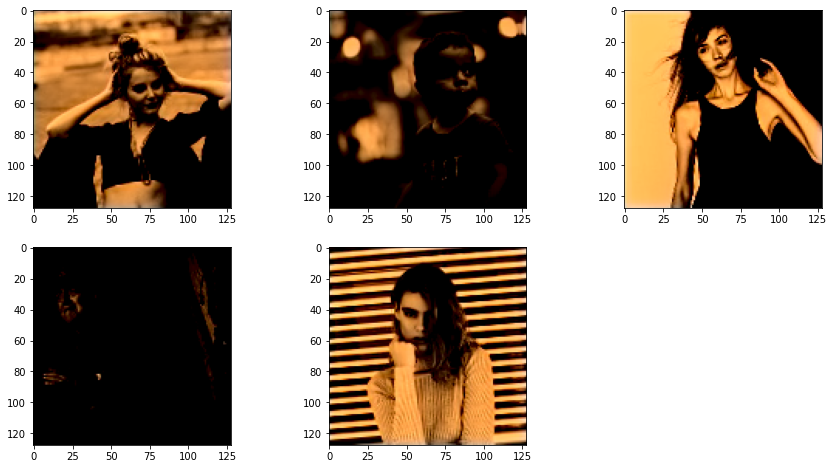

In [11]:
x_val, y_val, x_y_val = generate_training_images(Test, 5, testset_len, width, height, test_dir)
output_benchmark, _, _, _, _, _ ,_ = gan_core.predict(x_val)

plt.figure(figsize=(15,8), facecolor='w')
for i in range(len(output_benchmark)):
    cur = np.zeros((128, 128, 3))
    cur[:, :, 0] = x_val[i][:, :, 0] * 100
    cur[:, :, 1:] = output_benchmark[i] * 128
    plt.subplot(2, 3, i + 1)
    plt.imshow(lab2rgb(cur))

/usr/local/miniconda3/envs/dl/lib/python3.6/site-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 13314 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/miniconda3/envs/dl/lib/python3.6/site-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 9233 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/miniconda3/envs/dl/lib/python3.6/site-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 10254 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/miniconda3/envs/dl/lib/python3.6/site-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 10388 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/miniconda3/envs/dl/lib/python3.6/site-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 11764 pixels
  return xyz2rgb(lab2xyz(lab, illu

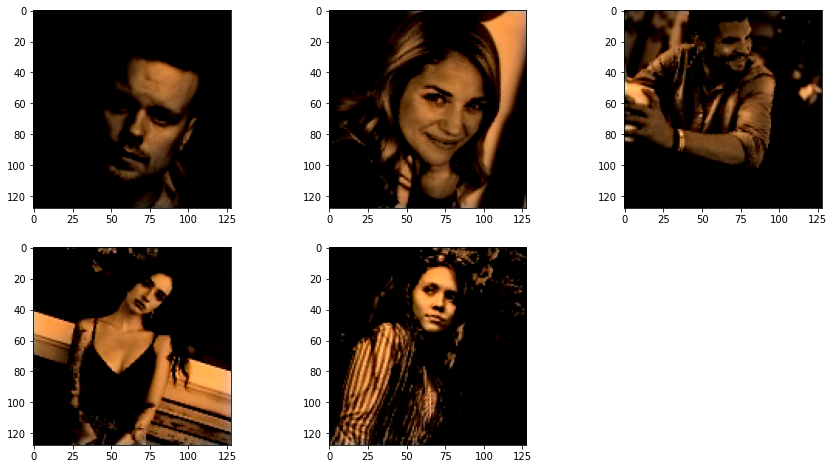

In [12]:
plt.figure(figsize=(15,8), facecolor='w')
for i in range(len(y_gen_full)):
    cur = np.zeros((128, 128, 3))
    cur[:, :, 0] = x_full[i][:, :, 0] * 100
    cur[:, :, 1:] = y_gen_full[i] * 128
    plt.subplot(2, 3, i + 1)
    plt.imshow(lab2rgb(cur))